# Support Vector Machine

Support Vector Machine (`SVM`) is a popular machine learning algorithm for solving classification and regression tasks. Its main idea is to find the best possible boundary or hyperplane that separates the different classes of data points. `SVM` chooses the hyperplane that separates the data points in a way that minimizes the classification error on unseen data.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import confusion_matrix

## Understanding SVM

Let's generate some data!

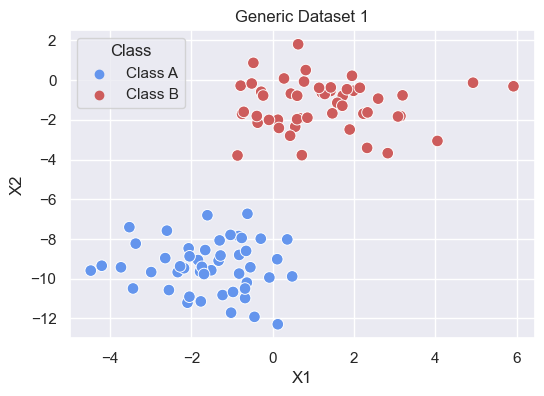

In [3]:
# Generating some data
X1, cl1 = make_blobs(n_samples=100, n_features=2, centers=2, random_state=2, cluster_std=1.2)
df1 = pd.DataFrame()
df1['X1'] = X1[:,0]
df1['X2'] = X1[:,1]
df1['Class'] = cl1
sns.set(rc={"figure.figsize":(6,4)}) # width=6, height=4
sns.scatterplot(x=df1.X1, y=df1.X2, s=70, hue=df1.Class.replace({0:'Class A', 1:'Class B'}), 
                palette=['cornflowerblue', 'indianred']).set_title("Generic Dataset 1");

There is more than one possible dividing line that can perfectly discriminate between the two classes.

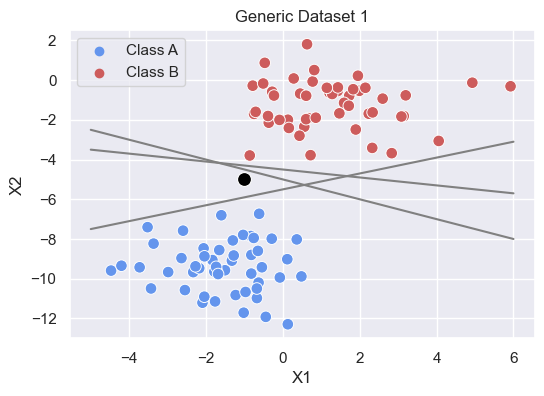

In [4]:
# scatterplot
sns.scatterplot(x=df1.X1, y=df1.X2, s=70, hue=df1.Class.replace({0:'Class A', 1:'Class B'}), 
                palette=['cornflowerblue', 'indianred']).set_title("Generic Dataset 1")
# Drawing some linear "models"
xval = np.linspace(-5, 6)
for m, b in [(-0.5, -5), (0.4, -5.5), (-0.2, -4.5)]:
    yval = m * xval + b     
    sns.lineplot(x=xval, y=yval, color='grey')
# Drawing a new point
sns.scatterplot(x=[-1], y=[-5], s=100, color='black');

- Grey lines are three very different separators that perfectly discriminate between the samples. 
- Depending on your choice, a new data point (the black one) will be assigned to one or another label! 
- Our simple intuition of "drawing a line between classes" is insufficient, and we must think deeper.

- Support vector machines offer one way to improve this: rather than simply drawing a line between the classes, we can draw a margin of some width that separate the classes. 

In [5]:
# Splitting the sample into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(df1[['X1','X2']], df1.Class, 
                                                        test_size=0.30, random_state=14)
print('Train Set: %i cases, \tTest Set: %i cases' %(X_train1.shape[0], X_test1.shape[0])) 

Train Set: 70 cases, 	Test Set: 30 cases


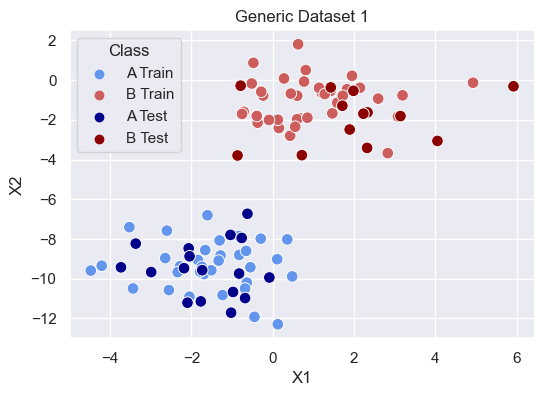

In [6]:
# Graphing training and testing sets
sns.scatterplot(x=X_train1.X1, y=X_train1.X2, s=70, hue=y_train1.replace({0:'A Train', 1:'B Train'}), 
                palette=['cornflowerblue', 'indianred'])
sns.scatterplot(x=X_test1.X1, y=X_test1.X2, s=70, hue=y_test1.replace({0:'A Test', 1:'B Test'}), 
                palette=['darkblue', 'darkred']).set_title("Generic Dataset 1");

In [7]:
# Saving training and testing data
data_train1 = pd.concat([X_train1, y_train1], axis=1)
data_test1  = pd.concat([X_test1, y_test1], axis=1)

In [8]:
# Initialize and train the SVM model
svm1 = SVC(kernel='linear', C=1E10).fit(X_train1, y_train1)

In [9]:
# Predictions with training and testing cases 
data_train1['Class_pred'] = svm1.predict(X_train1)
data_test1['Class_pred']  = svm1.predict(X_test1)

Let's create a function for plotting what is happening!

In [10]:
def plot_svc_decision_function(data, model):
    '''
    Plot the decision function for a 2D SVC
    data: DataFrame with the variables X1, X2, Class
    model: svm model    
    '''
    sns.scatterplot(x=data.X1, y=data.X2, s=70, hue=data.Class.replace({0:'Class A', 1:'Class B'}), 
                         palette=['cornflowerblue', 'indianred'])
    
    # Define minimum and maximum values for x and y axes
    x1_min, x1_max = data.X1.min() - 0.3, data.X1.max() + 0.3
    x2_min, x2_max = data.X2.min() - 0.3, data.X2.max() + 0.3    

    # Create grid to evaluate model
    x = np.linspace(x1_min, x1_max, 30)
    y = np.linspace(x2_min, x2_max, 30)
    Y, X = np.meshgrid(y, x)
    xy = pd.DataFrame(np.vstack([X.ravel(), Y.ravel()]).T, columns=['X1','X2']) 
    P = model.decision_function(xy).reshape(X.shape)
        
    # plot decision boundary and margins
    plt.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    # Plot support vectors
    sv = model.support_vectors_
    sns.scatterplot(x=sv[:,0], y=sv[:,1], s=150, linewidth=1, facecolor='none', edgecolor='black')
    plt.title(r'-SVM- (support vectors = %.d)' %len(sv)) 


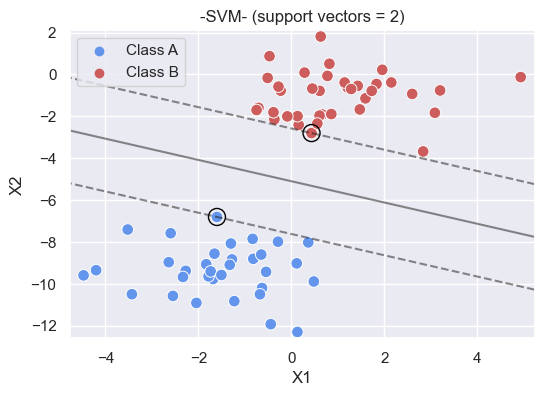

In [11]:
plot_svc_decision_function(data_train1, svm1);

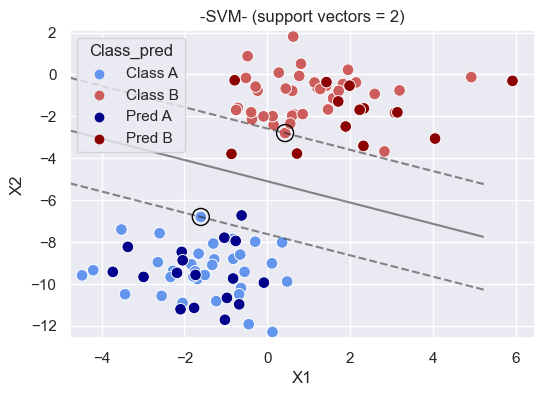

In [12]:
# Including test cases
plot_svc_decision_function(data_train1, svm1)
sns.scatterplot(x=data_test1.X1, y=data_test1.X2, s=70, 
                hue=data_test1.Class_pred.replace({0:'Pred A', 1:'Pred B'}), palette=['darkblue', 'darkred']);

In [13]:
# Getting the number of support vectors for each class
svm1.n_support_

array([1, 1])

In [14]:
# Getting the support vectors
svm1.support_vectors_

array([[-1.60297031, -6.80383522],
       [ 0.43123405, -2.79921652]])

In [15]:
# Getting indices of support vectors
svm1.support_

array([11, 26])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any point further from the margin on the right side does not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 30 points and first 60 points of this dataset

In [16]:
def plot_linear_svm(data):
    '''
    The function initialize, fit, and plot a linear SVM model
    data: DataFrame with the predictor variables X1 and X2
    '''
    model = SVC(kernel='linear', C=1E10)
    model.fit(data[['X1','X2']], data.Class)
    plot_svc_decision_function(data, model)   
    

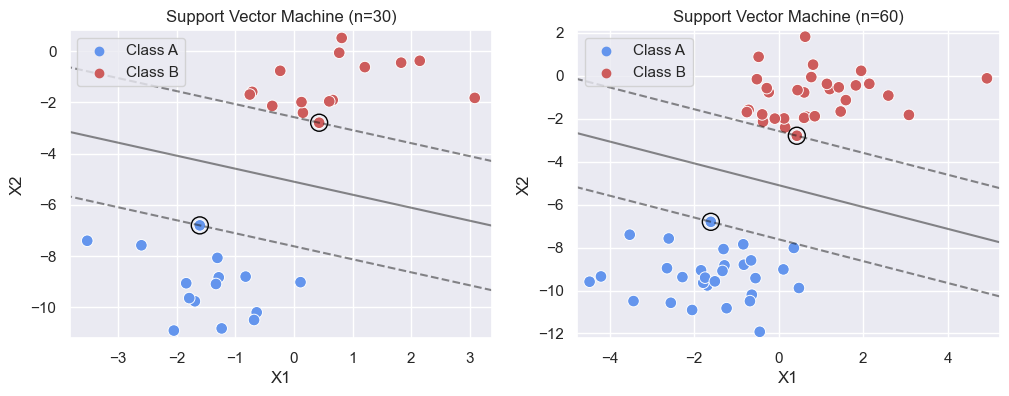

In [17]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plot_linear_svm(data_train1.head(30))
plt.title('Support Vector Machine (n=30)')

plt.subplot(122)
plot_linear_svm(data_train1.head(60))
plt.title('Support Vector Machine (n=60)');

In the left panel, we see the model and the support vectors for 30 training points. In the right panel, we have doubled the number of training points, but the model has not changed: the two support vectors from the left panel are still the support vectors from the right one. 

The SVM algorithm only considers the support vectors, which are the data points closest to the hyperplane, to determine the decision boundary. This makes SVMs particularly useful in high-dimensional spaces, where the number of non-support vectors can be much larger than the number of support vectors, and the computation time can be significantly reduced by ignoring the non-support vectors.

This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

## Kernel SVM

A kernel Support Vector Machine is a type of SVM used when the data is not linearly separable. The method transforms the data into a higher dimensional space, then separates the classes using a hyperplane.

Let's start by generating some particular data.

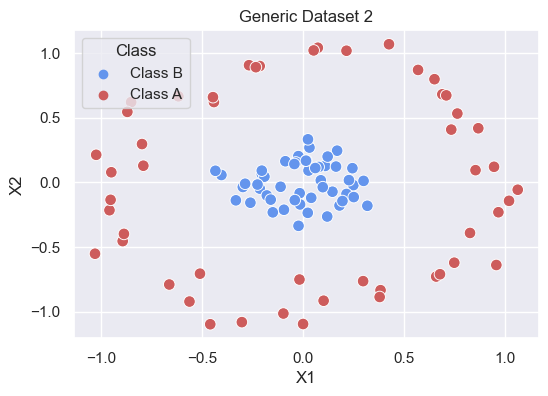

In [18]:
# Generating some data
X2, cl2 = make_circles(100, factor=.2, noise=.1, random_state=2)
df2 = pd.DataFrame()
df2['X1'] = X2[:,0]
df2['X2'] = X2[:,1]
df2['Class'] = cl2
sns.scatterplot(x=df2.X1, y=df2.X2, s=70, hue=df2.Class.replace({0:'Class A', 1:'Class B'}), 
                palette=['cornflowerblue', 'indianred']).set_title("Generic Dataset 2");

As you can see, classes are not linearly separable. No linear discrimination will ever be able to separate this data. We should use a different kernel.

In Scikit-Learn, we can apply kernel SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the kernel model hyperparameter.

In [19]:
# Splitting the sample into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(df2[['X1','X2']], df2.Class, 
                                                        test_size=0.30, random_state=39)
print('Train Set: %i cases, \tTest Set: %i cases' %(X_train2.shape[0], X_test2.shape[0])) 

Train Set: 70 cases, 	Test Set: 30 cases


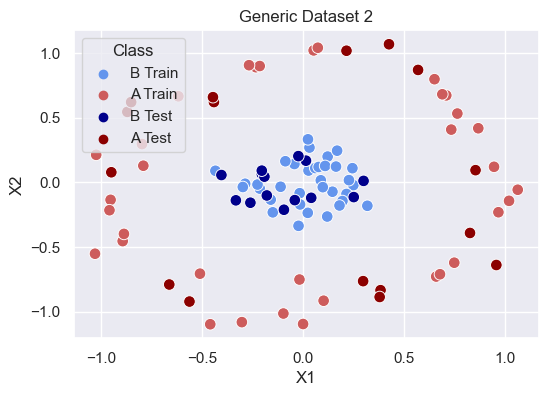

In [20]:
# Graphing training and testing sets
sns.scatterplot(x=X_train2.X1, y=X_train2.X2, s=70, hue=y_train2.replace({0:'A Train', 1:'B Train'}), 
                palette=['cornflowerblue', 'indianred'])
sns.scatterplot(x=X_test2.X1, y=X_test2.X2, s=70, hue=y_test2.replace({0:'A Test', 1:'B Test'}), 
                palette=['darkblue', 'darkred']).set_title("Generic Dataset 2");

In [21]:
# Saving training and testing data
data_train2 = pd.concat([X_train2, y_train2], axis=1)
data_test2  = pd.concat([X_test2, y_test2], axis=1)

In [22]:
# Initialize and fit the model
svm2 = SVC(kernel='rbf', C=1E6).fit(X_train2, y_train2) 

In [23]:
# Predictions with training and testing cases 
data_train2['Class_pred'] = svm2.predict(X_train2)
data_test2['Class_pred']  = svm2.predict(X_test2)

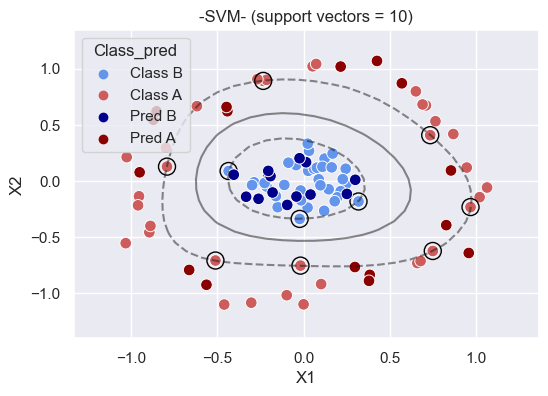

In [24]:
# Including testing cases
plot_svc_decision_function(data_train2, svm2)
sns.scatterplot(x=data_test2.X1, y=data_test2.X2, s=70, 
                hue=data_test2.Class_pred.replace({0:'Pred A', 1:'Pred B'}), palette=['darkblue', 'darkred']);

## Tuning the SVM: Softening Margins

What to do if the data has some amount of overlap?

The SVM implementation has a factor that softens the margin: it allows some points to creep into the margin if that allows a better fit.

The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
* The margin is hard for a large value of C, and points cannot lie in it.
* The margin is softer for smaller C and can grow to encompass some points. 

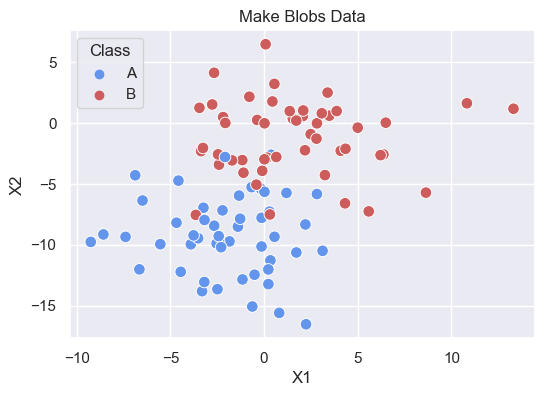

In [25]:
# The data
X3, cl3 = make_blobs(n_samples=100, n_features=2, centers=2, random_state=2, cluster_std=3)
df3 = pd.DataFrame()
df3['X1'] = X3[:,0]
df3['X2'] = X3[:,1]
df3['Class'] = cl3
sns.scatterplot(x=df3.X1, y=df3.X2, s=70, hue=df3.Class.replace({0:'A', 1:'B'}), 
                palette=['cornflowerblue', 'indianred']).set_title("Make Blobs Data");

In [26]:
# Splitting the sample into training and testing sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(df3[['X1','X2']], 
                                                        df3.Class, test_size=0.30, random_state=14)
print('Train Set: %i cases, \tTest Set: %i cases' %(X_train3.shape[0], X_test3.shape[0])) 

Train Set: 70 cases, 	Test Set: 30 cases


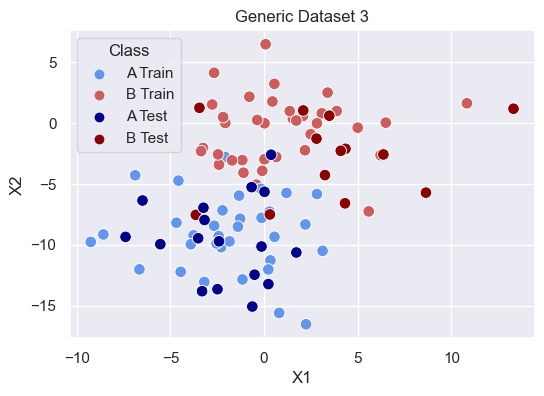

In [27]:
# Graphing training and testing sets
sns.scatterplot(x=X_train3.X1, y=X_train3.X2, s=70, hue=y_train3.replace({0:'A Train', 1:'B Train'}), 
                palette=['cornflowerblue', 'indianred'])
sns.scatterplot(x=X_test3.X1, y=X_test3.X2, s=70, hue=y_test3.replace({0:'A Test', 1:'B Test'}), 
                palette=['darkblue', 'darkred']).set_title("Generic Dataset 3");

In [28]:
# Saving training and testing data
data_train3 = pd.concat([X_train3, y_train3], axis=1)
data_test3  = pd.concat([X_test3,  y_test3], axis=1)

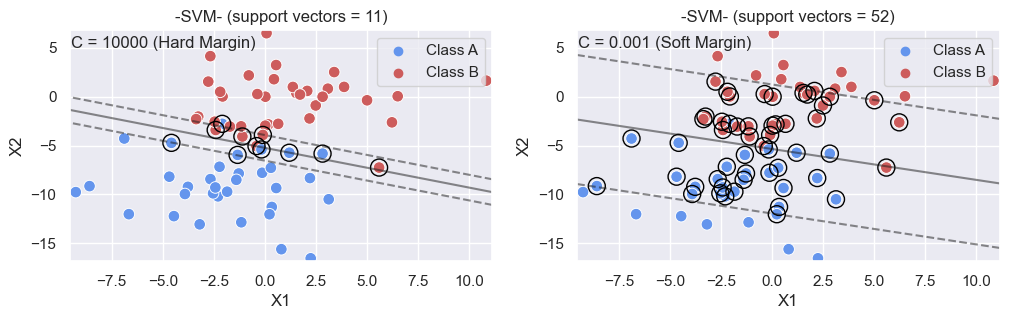

In [29]:
plt.figure(figsize=(12,3))

plt.subplot(121)
Ca = 10000
svm3a = SVC(kernel='linear', C=Ca).fit(X_train3, y_train3)
plot_svc_decision_function(data_train3, svm3a)
plt.text(-9.5, 5, r'C = %.i (Hard Margin)' %Ca)

plt.subplot(122)
Cb = 0.001
svm3b = SVC(kernel='linear', C=Cb).fit(X_train3, y_train3)
plot_svc_decision_function(data_train3, svm3b)
plt.text(-9.5, 5, r'C = %.3f (Soft Margin)' %Cb);

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure.

### Comparing the two models

In [30]:
# Generating new data
new_data = pd.DataFrame()
new_data['X1'] = np.random.uniform(data_train3.X1.min(), data_train3.X1.max(), size=1000)
new_data['X2'] = np.random.uniform(data_train3.X2.min(), data_train3.X2.max(), size=1000)
new_data['Class_3a'] = svm3a.predict(new_data[['X1','X2']])
new_data['Class_3b'] = svm3b.predict(new_data[['X1','X2']])

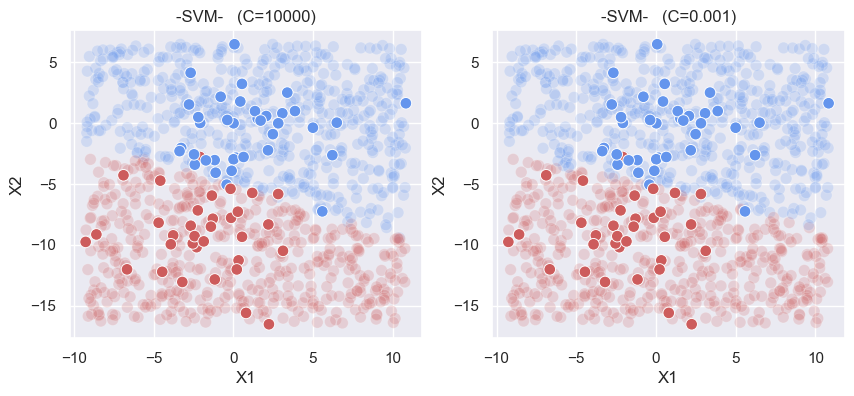

In [31]:
# Plotting boundaries
plt.figure(figsize=(10, 4))

plt.subplot(121)
sns.scatterplot(x=new_data.X1,  y=new_data.X2, s=70, hue=new_data.Class_3a, alpha=0.2, 
                palette=['indianred', 'cornflowerblue'], legend=False).set_title(r"-SVM-   (C=%i)" %Ca)
sns.scatterplot(x=X_train3.X1, y=X_train3.X2, s=70, hue=y_train3, 
                palette=['indianred', 'cornflowerblue'], legend=False);

plt.subplot(122)
sns.scatterplot(x=new_data.X1,  y=new_data.X2, s=70, hue=new_data.Class_3b, alpha=0.2, 
                palette=['indianred', 'cornflowerblue'], legend=False).set_title(r"-SVM-   (C=%.3f)" %Cb)
sns.scatterplot(x=X_train3.X1, y=X_train3.X2, s=70, hue=y_train3, 
                palette=['indianred', 'cornflowerblue'], legend=False);

In [32]:
new_data.head()

,X1,X2,Class_3a,Class_3b
0,8.111468,-3.492926,1,1
1,7.161767,4.800796,1,1
2,-4.441988,-14.146907,0,0
3,-8.027816,-8.365087,0,0
4,-2.589107,-4.389891,0,1


In [33]:
# Accuracy with the new_data
print(r'SVM Model (C=%i - Hard Margin) Accuracy = %.4f' %(Ca, 
                                svm3a.score(X=new_data[['X1','X2']], y=new_data.Class_3a)))
print(r'SVM Model (C=%.3f - Soft Margin) Accuracy = %.4f' %(Cb, 
                                svm3a.score(X=new_data[['X1','X2']], y=new_data.Class_3b)))

SVM Model (C=10000 - Hard Margin) Accuracy = 1.0000
SVM Model (C=0.001 - Soft Margin) Accuracy = 0.9840


## SVM: The Raisin Dataset

The dataset contains information about two varieties of raisins (Kecimen and Besni) grown in Turkey.

In [34]:
dfr = pd.read_csv('Raisin.csv')
print(dfr.shape)
dfr.head()

(900, 8)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


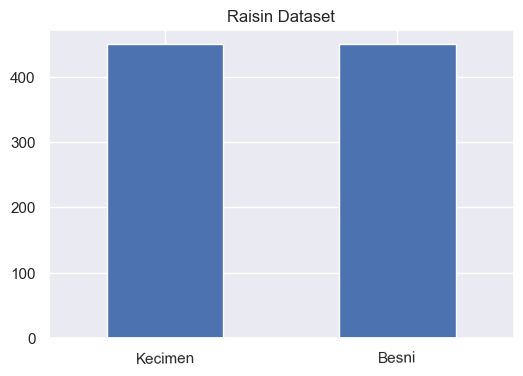

In [35]:
dfr.Class.value_counts().plot(kind='bar', rot=True, title='Raisin Dataset');

In [36]:
# Recoding the class variable
label_to_number = {'Kecimen': 0, 'Besni': 1}
dfr['Besni'] = dfr['Class'].map(label_to_number)
dfr.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class,Besni
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen,0
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen,0
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen,0
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen,0
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen,0


In [37]:
yr = dfr.Besni              # Target variable
Xr = dfr.drop(['Class','Besni'], axis=1)    
Xr.head()                   # Feature Matrix

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251


Predictor variables have very different scales; it is recommended to standardize them!

In [38]:
# Standardizing the Feature Matrix
ss = StandardScaler()
Xr = pd.DataFrame(ss.fit_transform(Xr), columns=Xr.columns)
Xr.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
0,-0.007186,0.097577,-0.023958,0.423142,-0.015709,1.106743,0.066274
1,-0.324217,-0.209012,-0.229292,0.224476,-0.304248,-0.287777,-0.161252
2,0.078292,0.097758,0.236988,0.186239,0.062113,-1.158250,0.155945
3,-1.074286,-1.245051,-0.915273,-1.069623,-1.076165,0.001711,-1.175915
4,-0.215393,-0.678958,0.727354,-2.409827,-0.238623,1.745259,-0.338639


In [39]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=23)
print('Train = %i cases \t Test = %i cases' %(len(Xr_train), len(Xr_test)))

Train = 720 cases 	 Test = 180 cases


In [40]:
# Saving training and testing data
data_train_r = pd.concat([Xr_train, yr_train], axis=1)
data_test_r = pd.concat([Xr_test, yr_test], axis=1)

### A SVM Model

In [41]:
# Initializing and training the model
svmr = SVC(kernel='linear', C=1).fit(X=Xr_train, y=yr_train)

In [42]:
# Print the accuracy score of the best model on training and testing sets
print("Accuracy on training cases = %.4f" %svmr.score(Xr_train, yr_train))
print("Accuracy on testing cases  = %.4f" %svmr.score(Xr_test, yr_test))

Accuracy on training cases = 0.8708
Accuracy on testing cases  = 0.8667


### Is there a better model?

In [43]:
# Define the hyperparameters to be tuned
parameters = {'kernel': ('linear', 'rbf', 'sigmoid'), 'C': [0.1, 1, 100, 1000]}

In [44]:
svc = SVC()                                 # Create a SVM object
clf = GridSearchCV(svc, parameters, cv=5)   # Create a GridSearchCV object
clf.fit(Xr_train, yr_train)                 # Fit the GridSearchCV object to the data

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 100, 1000],
                         'kernel': ('linear', 'rbf', 'sigmoid')})

In [45]:
best_estimator = clf.best_estimator_            # Get the best estimator
print("Best Parameters: ", clf.best_params_)    # Print the best set of hyperparameters

Best Parameters:  {'C': 0.1, 'kernel': 'rbf'}


In [46]:
# Print the accuracy score of the best model on training and testing sets
print("Accuracy on training cases = %.4f" %clf.score(Xr_train, yr_train))
print("Accuracy on testing cases  = %.4f" %clf.score(Xr_test, yr_test))

Accuracy on training cases = 0.8736
Accuracy on testing cases  = 0.8611


## References

- CINAR I., KOKLU M. and TASDEMIR S., (2020), Classification of Raisin Grains Using Machine Vision and Artificial Intelligence Methods. Gazi Journal of Engineering Sciences, vol. 6, no. 3, pp. 200-209, December, 2020. DOI: https://dergipark.org.tr/tr/download/article-file/1227592
- Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- VanderPlas, J. (2017) Python Data Science Handbook: Essential Tools for Working with Data. USA: O’Reilly Media, Inc. chapter 5